# Astuto NLP Problem Statement:
## Business Context
We are building a Customer Experience platform for B2B Customers. One of the core component of this Customer Experience Platform is our NLP Engine, which would consume textual data and generate insights.
## Problem statement:
We have recently started working building an initial iteration for an Ecommerce customer with their Reviews data.
Let us use a dataset available in Kaggle for our reference. Link to ecommerce reviews data
https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products?select=Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv

## Problem formulation and assumptions
We need to extract meaningful insights from user reviews in this project. User reviews generally contain useful aspects of the product usage. Fetching these aspects as keywords / keyphrase will be valuable addition.

There are numerous studies in the area of keyphrase extraction. They can majorly be categorized into 4 approaches

1.   Co-occurrence based
2.   Graph based
3.   Deep Extractive models
4.   Deep Generative models

There are a few off-the-shelf libraries available for Co-occurrence and Extractive approaches. We will try some of them to get an understanding of their capabilities.


**Assumptions**
*   Feedback from business team is that previous approach was 'very generic', this generally signify initial approach has high recall. We should strive to come up with approach with high precision.
*   Extracting 'meaningful labels': Adding context to extracted keywords will be beneficial. One way to achieve this is to increase the context window.




## Accessing Data
I have put the data in my drive, will fetch and unzip it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/LeadSquared_Assignment/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.zip

Archive:  /content/drive/MyDrive/LeadSquared_Assignment/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.zip
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv  


## Importing libraries
Here, we import few required libraries. For other libraries, we will install and import them as and when required instead of importing in the begining. This requires less resource in Colab environment.

In [2]:
import nltk
import pandas as pd
from typing import *

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Read data
Reading the data as a dataframe.

In [4]:
products_df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
products_df.tail(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
4998,AVqkIdZiv8e3D1O-leaJ,2017-03-06T14:59:25Z,2017-09-04T11:19:31Z,"Fire Tablet with Alexa, 7"" Display, 16 GB, Mag...",B018Y224PY,Amazon,"Tablets,Fire Tablets,Electronics,iPad & Tablet...",Electronics,https://images-na.ssl-images-amazon.com/images...,"841667103150,0841667103150,firetabletwithalexa...",Amazon,B018Y224PY,2016-09-02T00:00:00.000Z,2017-05-22T21:44:38Z,"2017-04-30T02:06:56.574Z,2017-06-07T08:20:53.942Z",True,NaN,0,5,http://reviews.bestbuy.com/3545/5025900/review...,I had some thoughts about getting this for a 5...,Very sturdy for a 5 year old,Mrbilly,"https://www.barcodable.com/upc/841667103150,ht..."
4999,AVqkIdZiv8e3D1O-leaJ,2017-03-06T14:59:25Z,2017-09-04T11:19:31Z,"Fire Tablet with Alexa, 7"" Display, 16 GB, Mag...",B018Y224PY,Amazon,"Tablets,Fire Tablets,Electronics,iPad & Tablet...",Electronics,https://images-na.ssl-images-amazon.com/images...,"841667103150,0841667103150,firetabletwithalexa...",Amazon,B018Y224PY,2016-05-19T00:00:00.000Z,2017-04-04T09:55:17Z,"2017-04-03T03:55:09.054Z,2017-04-30T02:03:18.1...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5025900/review...,"this is a steal, have 8 gb model as well.This ...",great little tablet,tabman,"https://www.barcodable.com/upc/841667103150,ht..."


#### Analysing Input Text
We observe that there are many columns which are not required for our purposes. We will remove those and only keep the required ones. 

In [5]:
products_df = products_df[['id', 'reviews.text', 'reviews.rating', 'reviews.title', 'primaryCategories', 'name']].copy()
products_df.rename(columns={'reviews.text': 'review', 'reviews.rating': 'rating', 'reviews.title': 'title', 'primaryCategories': 'category'}, inplace=True)
products_df.head(2)

,id,review,rating,title,category,name
0,AVqVGZNvQMlgsOJE6eUY,I thought it would be as big as small paper bu...,3,Too small,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation..."
1,AVqVGZNvQMlgsOJE6eUY,This kindle is light and easy to use especiall...,5,Great light reader. Easy to use at the beach,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation..."


In [6]:
products_df.category.value_counts()

Electronics                    3276
Electronics,Hardware           1435
Office Supplies,Electronics     265
Electronics,Media                24
Name: category, dtype: int64

As we see, majority of the reviews are coming for 'Electronics' category. Different category might different approach, for example, electronic items can have aspect 'battery life' whereas books has no such aspect. However, our approach here will not vary based on category.

Lets deduplicate our data.

In [9]:
## Remove rows if review text is duplicate:
print(f'Reviews remaining before deduplication: [{products_df.shape[0]}]')
products_df.drop_duplicates(subset=['review'])
print(f'Reviews remaining after deduplication: [{products_df.shape[0]}]')

Reviews remaining before deduplication: [5000]
Reviews remaining after deduplication: [5000]


We will get the tokens from the reviews to get various token frequency based statistics.

In [7]:
products_df['review_tokens'] = products_df['review'].str.lower().str.split()
products_df['token_count'] = products_df['review'].str.lower().str.split().str.len()
products_df.head(2)

,id,review,rating,title,category,name,review_tokens,token_count
0,AVqVGZNvQMlgsOJE6eUY,I thought it would be as big as small paper bu...,3,Too small,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","[i, thought, it, would, be, as, big, as, small...",41
1,AVqVGZNvQMlgsOJE6eUY,This kindle is light and easy to use especiall...,5,Great light reader. Easy to use at the beach,Electronics,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","[this, kindle, is, light, and, easy, to, use, ...",12


One important point to note here is that a single product can have multiple reviews. We need to aggregate KeyPhrase extraction over all the reviews for a single product.

Let us see how many unique products are present in the data.

In [10]:
unique_products = products_df.id.value_counts()
unique_products

AVqkIhwDv8e3D1O-lebb    797
AWFUWc8THh53nbDRF6YO    650
AWMjT0WguC1rwyj_rFh3    590
AVph0EeEilAPnD_x9myq    561
AVpjEN4jLJeJML43rpUe    467
AVpgdkC8ilAPnD_xsvyi    371
AVpfpK8KLJeJML43BCuD    225
AVqVGWLKnnc1JgDc3jF1    217
AWK8z0pOIwln0LfXlSxH    195
AVqVGZSEQMlgsOJE6eUc    159
AVpidLjVilAPnD_xEVpI    106
AVqkIdZiv8e3D1O-leaJ    101
AVqVGZNvQMlgsOJE6eUY     96
AVphPmHuilAPnD_x3E5h     82
AVqkIh9HQMlgsOJE6fu_     70
AVqkIh8WQMlgsOJE6fu-     58
AVqkIj9snnc1JgDc3khU     53
AVqkIhkhv8e3D1O-lebZ     51
AVqkIiKWnnc1JgDc3khH     40
AVqVGZN9QMlgsOJE6eUZ     39
AVqVGZO3nnc1JgDc3jGK     24
AVpfIfGA1cnluZ0-emyp     22
AVpftoij1cnluZ0-p5n2     22
AV-XeQLWuC1rwyj_gbP5      4
Name: id, dtype: int64

In [11]:
print(f'There are total [{len(unique_products)}] products.')
print(f'Product [{products_df.loc[products_df["id"] == unique_products.index[0]]["name"].iloc[0]}] has most reviews [{unique_products.iloc[0]}].')
print(f'Product [{products_df.loc[products_df["id"] == unique_products.index[-1]]["name"].iloc[0]}] has least reviews [{unique_products.iloc[-1]}].')

There are total [24] products.
Product [All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta] has most reviews [797].
Product [Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player] has least reviews [4].


Filter out the product id with the least number of reviews for faster testing and evaluation purposes.

In [51]:
product_least_review = unique_products.index[-1]

In [ ]:
from collections import Counter, OrderedDict

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
token_freqs = Counter(tokens_unique)

Lets us see the token frequencies

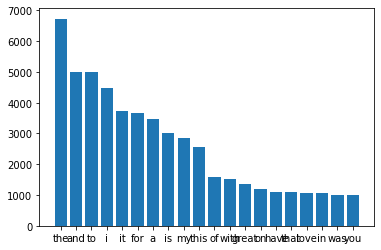

In [143]:
n = 20
top_n_tokens_odict = OrderedDict(token_freqs.most_common(n))
bottom_n_tokens_odict = OrderedDict(token_freqs.most_common()[:-n-1:-1])

plt.bar(top_n_tokens_odict.keys(), top_n_tokens_odict.values())
plt.show()

As expected, majority of the high frequency words are stopwords.
Let us remove stopwords and clean up a little.

In [12]:
import unicodedata, re

In [13]:
wnl = nltk.stem.WordNetLemmatizer()

In [14]:
def get_clean_text(txt:str, stopwords:list=stopwords, return_tokens:bool=False) -> Union[List, str]:
    """ Cleans a str by normalizing, lowercasing and removing stopwords """
    txt = (unicodedata.normalize('NFKD', txt).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', txt).split()

    clean_txt = [wnl.lemmatize(word) for word in words if word not in stopwords]

    if return_tokens:
        return clean_txt
    else:
        return ' '.join(clean_txt)

In [1]:
sanity_text = 'hello there, sam'
get_clean_text(sanity_text, return_tokens=True)

assert get_clean_text(sanity_text) == 'hello sam'
assert get_clean_text(sanity_text, return_tokens=True) == ['hello', 'sam']

NameError: ignored

In [17]:
from functools import partial
get_clean_text_tokens = partial(get_clean_text, return_tokens=True)

In [21]:
products_df['review_tokens_cleaned'] = products_df['review'].apply(get_clean_text_tokens)
products_df['review_tokens_cleaned']

0       [thought, would, big, small, paper, turn, like...
1           [kindle, light, easy, use, especially, beach]
2       [didnt, know, much, id, use, kindle, went, low...
3       [100, happy, purchase, caught, sale, really, g...
4       [solid, entry, level, kindle, great, kid, gift...
                              ...                        
4995            [great, tablet, price, amazon, good, job]
4996    [tablet, perfect, size, easy, use, read, play,...
4997    [purchased, son, room, upgrade, memory, allow,...
4998    [thought, getting, 5, year, old, get, screen, ...
4999               [steal, 8, gb, model, wellthis, punch]
Name: review_tokens_cleaned, Length: 5000, dtype: object

In [22]:
products_df['review_cleaned'] = products_df['review'].apply(get_clean_text)
products_df['review_cleaned']

0       thought would big small paper turn like palm t...
1                  kindle light easy use especially beach
2       didnt know much id use kindle went lower end i...
3       100 happy purchase caught sale really good pri...
4       solid entry level kindle great kid gifted kid ...
                              ...                        
4995                   great tablet price amazon good job
4996    tablet perfect size easy use read play game pu...
4997    purchased son room upgrade memory allow book g...
4998    thought getting 5 year old get screen protecto...
4999                      steal 8 gb model wellthis punch
Name: review_cleaned, Length: 5000, dtype: object

We need to generate keywords per product by aggregating over all reviews.

In [43]:
product_dfs = {}
products_keywords = {}
for product_id, product_review_count in unique_products.iteritems():
    product_reviews = products_df.loc[products_df["id"] == product_id]
    product_dfs[product_id] = product_reviews

In [42]:
product_dfs[product_least_review]

,id,review,rating,title,category,name,review_tokens,token_count,review_tokens_cleaned,review_cleaned
941,AV-XeQLWuC1rwyj_gbP5,A lazy mans drean when it is combined with Ale...,5,Awesome!,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,"[a, lazy, mans, drean, when, it, is, combined,...",23,"[lazy, man, drean, combined, alexa, get, harmo...",lazy man drean combined alexa get harmony hub ...
942,AV-XeQLWuC1rwyj_gbP5,I really enjoy my Fire stick. It's really easy...,5,This is a great piece of equipment,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,"[i, really, enjoy, my, fire, stick., it's, rea...",11,"[really, enjoy, fire, stick, really, easy, use]",really enjoy fire stick really easy use
943,AV-XeQLWuC1rwyj_gbP5,Really cool device! Instantly noticed the diff...,5,NaN,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,"[really, cool, device!, instantly, noticed, th...",23,"[really, cool, device, instantly, noticed, dif...",really cool device instantly noticed differenc...
944,AV-XeQLWuC1rwyj_gbP5,Love it! Works great. One in each of the main ...,5,love it!,Electronics,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,"[love, it!, works, great., one, in, each, of, ...",11,"[love, work, great, one, main, room]",love work great one main room


One of the simplest approach to extract keywords is to get frequent n-grams. Let us see top n-grams from both raw and clean texts. 

In [23]:
def get_ngrams(txt:List[list]):
    tokens_unique = []
    for tokens in txt:
        tokens_unique.extend(tokens)
    return tokens_unique

In [52]:
product_ngrams = get_ngrams(product_dfs[product_least_review]['review_tokens'])
(pd.Series(nltk.ngrams(product_ngrams, 3)).value_counts())[:5]

(compared, to, the)                 3
(i, like, the)                      3
(paperwhite,, especially, since)    2
(my, paperwhite, to)                2
(it, is, to)                        2
dtype: int64

In [53]:
product_ngrams_cleaned = get_ngrams(product_dfs[product_least_review]['review_tokens_cleaned'])
(pd.Series(nltk.ngrams(product_ngrams_cleaned, 3)).value_counts())[:5]

(friend, bought, voyage)      2
(extra, cost, compared)       2
(gave, paperwhite, friend)    2
(easy, turn, page)            2
(know, really, worth)         2
dtype: int64

## Off-The-Shelf Libraries
We'll use some of the unsupervised keyphrase extraction libraries.

In [52]:
!pip install yake

     |████████████████████████████████| 60 kB 6.5 MB/s 
     |████████████████████████████████| 137 kB 66.2 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.8.9-cp37-cp37m-linux_x86_64.whl size=73236 sha256=cdb32b12766fa9c6a098e44bf59a6701bb28b3dfd92534c8eba693eff1fd4884
  Stored in directory: /root/.cache/pip/wheels/32/a9/ef/5d8742e72deaf0d1de327a180d008c2c0299367581800ea73f
  Created wheel for segtok: filename=segtok-1.5.10-py3-none-any.whl size=25030 sha256=2a7ea4a08e8f5e6fa22d813d775b0ffd7a483397ef9ff0befe52ff6f9d4b6570
  Stored in directory: /root/.cache/pip/wheels/67/b7/d0/a121106e61339eee5ed083bc230b1c8dc422c49a5a28c2addd
Successfully built jellyfish segtok


In [56]:
import yake

**Setting up hyperparameters**

YAKE library offers some option to customize our requirements. They are explained below:

In [61]:
language = "en" ## Language code should match input text language
max_ngram_size = 6 ## Maximum number of tokens in each keyword
deduplication_threshold = 0.5 ## Limits the duplication of words in different keywords
numOfKeywords = 5  ## Maximum number of keywords to generate
deduplication_algo = 'seqm' ## Choices: leve|jaro|seqm
windowSize = 5

yake_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size,
                                          dedupLim=deduplication_threshold, 
                                          top=numOfKeywords, windowsSize=windowSize, 
                                          dedupFunc=deduplication_algo, features=None)

We set higher `windowSize` to extract keywords with more contexts. Additionally, a high `max_ngram_size` also ensures specific keywords.

`deduplication_threshold` ensures similar phrases are avoided.

In [78]:
idx = 5
print(product_dfs[product_least_review]['review'].iloc[idx])
yake_kw_extractor.extract_keywords(product_dfs[product_least_review]['review'].iloc[idx])

This is a great reader, it feels like the best evolution of the Paperwhite. The auto-brightness works fine and is unnoticeable and it feels good in the hands. The new page squeeze feature is nice as is the haptic feedback when you squeeze the bezel.The power button is also much better placed now and the glass screen makes swiping and tapping the bookmark and location corner areas much easier. The backlight is now much more uniform than my 1st gen Paperwhite.The only issue I have is when displaying black blocks like the tree silhouette, I have what looks like a tiny bad pixel that kind of twinkles. And of course, this thing is expensive when compared to the Paperwhite.


[('evolution of the Paperwhite', -0.7238351879001719),
 ('feels like the best evolution', -0.18439937611624463),
 ('feature is nice', 0.0),
 ('swiping and tapping', 0.0),
 ('glass screen makes swiping and tapping', 0.0)]

In [94]:
def extract_keywords_yake(txt:str):
    keywords = []
    keyword_tuples = yake_kw_extractor.extract_keywords(txt)
    ## Process extracted keywords: (Lower score has higher relevance)
    for kw in keyword_tuples:
        keywords.append(kw[0])

    return keywords

We will estimate time requirement for each library as that could be one of the important considerations.

In [89]:
%%timeit
extract_keywords_yake(product_dfs[product_least_review]['review'].iloc[idx])

10 loops, best of 5: 52.2 ms per loop


In [90]:
extract_keywords_yake(product_dfs[product_least_review]['review'].iloc[idx])

['evolution of the Paperwhite',
 'feels like the best evolution',
 'feature is nice',
 'swiping and tapping',
 'glass screen makes swiping and tapping']

In [63]:
!pip install rake_nltk

In [68]:
from rake_nltk import Rake
rake_nltk_var = Rake()

In [69]:
def extract_keywords_rake(txt:str):
    rake_nltk_var.extract_keywords_from_text(txt)
    keywords = rake_nltk_var.get_ranked_phrases()

    return keywords

In [70]:
%%timeit
extract_keywords_rake(product_dfs[product_least_review]['review'].iloc[idx])

The slowest run took 85.44 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 175 µs per loop


In [91]:
extract_keywords_rake(product_dfs[product_least_review]['review'].iloc[idx]) [:5]

['location corner areas much easier',
 'glass screen makes swiping',
 'also much better placed',
 'displaying black blocks like',
 'new page squeeze feature']

In [72]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [73]:
def extract_keywords_spacy(txt:str):
    doc = nlp(txt)
    # print(doc.ents)

    return doc.ents

In [79]:
%%timeit
extract_keywords_spacy(product_dfs[product_least_review]['review'].iloc[idx]) ## We are ignoring the time taken in loading the spacy model.

10 loops, best of 5: 22.3 ms per loop


In [80]:
extract_keywords_spacy(product_dfs[product_least_review]['review'].iloc[idx])

(Paperwhite, 1st, Paperwhite)

So far we have explored co-occurrence based approaches, let us look into one Deep Extractive approach based on BERT. 

In [77]:
!pip install keybert ## https://pypi.org/project/keybert/

  Using cached keybert-0.5.0.tar.gz (19 kB)
  Using cached sentence-transformers-2.1.0.tar.gz (78 kB)
  Using cached rich-10.14.0-py3-none-any.whl (213 kB)
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
  Using cached transformers-4.12.5-py3-none-any.whl (3.1 MB)
  Using cached tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached huggingface_hub-0.1.2-py3-none-any.whl (59 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x55fbd39ac000 @  0x7f42923e7615 0x55fb998a94cc 0x55fb999

In [81]:
from keybert import KeyBERT

kb_model = KeyBERT()

In [92]:
def extract_keywords_keybert(txt:str, ngrams_min:int=2, ngrams_max:int=4, stop_words=None):
    keyword_tuples = kb_model.extract_keywords(txt, keyphrase_ngram_range=(ngrams_min, ngrams_max), stop_words=stop_words)
    
    keywords = []
    ## Process extracted keywords: (Lower score has higher relevance)
    for kw in keyword_tuples:
        keywords.append(kw[0])
    return keywords

In [83]:
%%timeit
extract_keywords_keybert(product_dfs[product_least_review]['review'].iloc[idx])

1 loop, best of 5: 1.3 s per loop


BERT based approach has significant time and computational requirement over co-occurrence based approaches.

In [93]:
extract_keywords_keybert(product_dfs[product_least_review]['review'].iloc[idx])

['paperwhite the auto brightness',
 'compared to the paperwhite',
 'paperwhite the only issue',
 '1st gen paperwhite',
 'the paperwhite']

Let us aggregate over the reviews for each product.
We aggregate by considering extracted keyphrases from all reviews and counting their frequency. Finally, take most frequent keyphrases as our answer.

However, this approach generates very similar keywords. To counter that we add a simple deduplication based on a similarity score which I have defined below.

In [107]:
def get_keywords_for_product(df: pd.DataFrame):
    keywords = []
    for idx, row in df.iterrows():
        review = row['review']
        kws = extract_keywords_rake(review)
        keywords.extend(kws)

    return keywords

We define a scorer which takes repeated elements into account. This is inspired from Jaccard Distance. 

In [172]:
def repeated_sim_score(txt1, txt2):
    """ Calculates similarity score with allowing repeated elements"""
    txt1_split = txt1.split()
    txt2_split = txt2.split() 
    txt1_c = Counter(txt1_split)
    txt2_c = Counter(txt2_split)
    intersection = (txt1_c - txt2_c) + (txt2_c - txt1_c)
    intersection_count = sum(intersection.values())

    return (intersection_count/(len(txt1_split) + len(txt2_split) - intersection_count + 1))

In [170]:
txt1 = 'the paperwhite especially'
txt2 = 'the paperwhite especially since'
txt2 = 'fire hd'

repeated_sim_score(txt1, txt2)

Counter({'the': 1, 'paperwhite': 1, 'especially': 1, 'fire': 1, 'hd': 1}) Counter({'the': 1, 'paperwhite': 1, 'especially': 1}) Counter({'fire': 1, 'hd': 1})


5.0

In [175]:
def aggregate_keywords(keywords: List, n=5, diversify=True):
    keyword_freqs = Counter(keywords)
    top_keywords_odict = OrderedDict(keyword_freqs.most_common())
    keywords_selected = []
    if diversify: ## This is another level of deduplication which works across reviews
        for keyword in top_keywords_odict.keys():
            if not keywords_selected:
                keywords_selected.append(keyword)
                continue
            elif len(keywords_selected) >= n:
                break

            similar_flag = False
            for already_selected_keyword in keywords_selected:
                score = repeated_sim_score(already_selected_keyword, keyword)
                if score < 0.5:
                    similar_flag = True
            
            if not similar_flag:
                keywords_selected.append(keyword)
                similar_flag = False

    return keywords_selected

In [126]:
product_keywords = get_keywords_for_product(product_dfs[product_least_review])
# product_keywords

In [176]:
final_keywords = aggregate_keywords(product_keywords, n=5)
final_keywords

['compared to the paperwhite',
 'the paperwhite especially',
 'fire hd',
 'sunlight other than fire',
 'read in the sunlight']

Extracting keywords for all products

In [181]:
def get_keywords_for_all(dfs:Dict, n=5):
    final_keywords = {}
    for product, df in dfs.items():
        product_keywords = get_keywords_for_product(df)
        final_keywords[product] = aggregate_keywords(product_keywords, n=n)

    return final_keywords

In [182]:
keywords = get_keywords_for_all(product_dfs, n=5)

In [185]:
for idx, keyword in keywords.items():
    print(f'Keywords for Product [{products_df.loc[products_df["id"] == idx]["name"].iloc[0]}] are: \n{keyword}.')

Keywords for Product [All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta] are: 
['this tablet', 'kindle fire', 'great tablet', 'easy to use', 'good tablet'].
Keywords for Product [Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen] are: 
['the echo show', 'amazon echo', 'smart home', 'easy to set up', 'easy to use'].
Keywords for Product [Amazon - Echo Plus w/ Built-In Hub - Silver] are: 
['the echo plus', 'amazon echo', 'easy to set up', 'love alexa', 'smart home'].
Keywords for Product [Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case] are: 
['this tablet', 'great tablet', 'tablet for kids', 'easy to use', 'parental controls'].
Keywords for Product [Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue] are: 
['this tablet', 'great tablet', 'fire tablet', 'kindle fire', 'easy to use'].
Keywords for Product [Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black] are: 
['this tabl

#### Qualitative Investigation
We saw 4 approaches here, let us manually investigate the quality of keyphrases extracted by each apporach.

In [95]:
def process_texts(df: pd.DataFrame):
    yake_keywords_set = set()
    rake_keywords_set = set()
    spacy_keywords_set = set()
    keybert_keywords_set = set()
    review_wise_keywords = []
    for idx, row in df.iterrows():
        review = row['review']
        yake_kws = extract_keywords_yake(review)
        # print(yake_kws)
        rake_kws = extract_keywords_rake(review)
        # print(rake_kws)
        spacy_kws = extract_keywords_spacy(review)
        # print(spacy_kws)
        keybert_kws = extract_keywords_keybert(review)
        # print(keybert_kws)
        yake_keywords_set.update(yake_kws)
        rake_keywords_set.update(rake_kws)
        spacy_keywords_set.update(spacy_kws)
        keybert_keywords_set.update(keybert_kws)
        # review_wise_keywords[idx] = kws

    return yake_keywords_set, rake_keywords_set, spacy_keywords_set, keybert_keywords_set

yake_keywords_set, rake_keywords_set, spacy_keywords_set, keybert_keywords_set = \
    process_texts(product_dfs[product_least_review])
print(yake_keywords_set)
print(rake_keywords_set)
print(spacy_keywords_set)
print(keybert_keywords_set)

{'Love', 'expensive', 'Love Love', 'huge', 'huge selection of books', 'Fast', 'side pressure page advance', 'connected to WIFI to download books', 'read in the sunlight', 'high class e reader', 'good battery life', 'Enjoy my summer reading', 'good', 'easy', 'unnecessary now I am wishing', 'great back lighting', 'high', 'friend and bought the Voyage', 'selection', 'product', 'big tech heaven in the sky', 'easier to read in all lightings', 'needed', 'works great', 'Kindle and cover were a gift', 'small size fits my small hands', 'Voyage', 'backlit so needed', 'wife', 'easier to read', 'complaints works great and the battery', 'solid', 'daughter', 'Love the new Voyage', 'wishing I had purchased', 'gift for my wife', 'fantastic product', 'back light nad easier to read', 'Kindle', 'handle', 'happy and satisfiedEasier to handle', 'reading books', 'Kindle Voyage', 'summer reading and a regular tablet', 'absolutely loves', 'heard', 'e-reader', 'needed something to read', 'happy', 'evolution of

* **YAKE**: Generates mix of single and multi word keyphrases. Single word phrases can be removed easily. YAKE is able to extract useful keyphrases such as 'good battery life'. However, it takes 52ms per example.
* **RAKE**: Is the fastest, but it might be caching the result. Is able to extract useful keyphrase such as 'initially disappointed' or 'quickly learned'
* **Spacy**: Extracts single word keyphrases (e.g. Kindle) and it does not provide any option to customized either. However, it is one of the fastest running option.
* **KeyBERT**: is able to extract meaningful keyphrases such as 'lightweight it was very' or 'the battery is awesome'. However, it is the slowest, taking 1+ sec per example. Knowledge Distillation may be applied for faster response. 

## Future Directions

Although we saw a few approaches along with their advantage and demerits, there are various approaches which can be employed to enrich the understanding. One such possibility is Aspect-based Sentiment Analysis (ABSA). ABSA tries to understand the sentiment of a text given the aspect. For example, in a review about restaurant, a user can be happy about food taste but can have negative  about service.

If we analyse the sentiment of the user with respect to each extracted keyphrase and color code using aggregated sentiment, that will add more value. 

**Given sufficient time and resources I would go with below approach:** 

1.   Train a model with language modelling task using our unsupervised products data 
2.   Calculate perplexity over any keyphrase extraction datasets [1] to get most similar examples from multiple datasets
3.   Consider the examples with lowest perplexity scores along with their labels, these can be used as seed data for our model (seed_data_1)
4.   Assign labels by myself to few (approx 100) examples (seed_data_2)
5.   Use a portion (60%) of the seed_data_2 for evaluation 
6.   Mix rest 40% of seed_data_2 with seed_data_1
7.   Retrain the initial model for KeyPhrase Extraction with additional extraction head
8.   Iterate multiple times following above mentioned process.
9.   Additional: Use different weights for loss calculation for seed_data_1 and seed_data_2 during training

[1] Key Phrase Extraction Datasets: https://github.com/boudinfl/ake-datasets
